In [1]:
using Plots, StatsBase, LinearAlgebra, Statistics, JLD2, Dates, StaticArrays, JSON, CUDA

# data structure module
include("spin_sim_functions_limited.jl")
using .spin_sim_functions_limited

# function libraries
include("spin_sims_new_limited.jl");

# SET VARIABLES

In [3]:
# make the parameter file
params = make_params()

# interaction
params["α"] = 0.03;

# number of frequencies
params["n"] = (50, 50)

# make a lattice, pbc = periodic bc or not
params["hlk"] = [1; 1]
params["θ"] = [π/2]
params["r"], params["spin_idx"] = make_lattice(params["hlk"], params["θ"], params["n"])

# make the stencil
params["ξ"] = 10
params["decay_power"] = 4
params["M_stencil"] = make_stencil(params["r"], params["ξ"], params["decay_power"])

# dissipation parameters
params["Γ"] = (0, 0, 10^-3);

# load the pulsing parameters
params["flip_angle"] = π/2
params["phases"] = (0, π/2)

# cpmg parameters
params["echo_time"] = 100e-6 # collect(LinRange(50e-6, 300e-6, 20));;
params["num_echoes"] = convert.(Int64, round.(1000e-6./params["echo_time"]));;

# ASSIGN VARIABLES TO PARAMETER FILE

In [4]:
# set variables
vars = [];
params["vars"] = vars;

In [8]:
idx_list, d = make_idx(vars, params)
M_list = Array{Any}(undef, d)
echoes = Array{Any}(undef, d)

for i in idx_list

    # generate temporary parameters
    tparams = make_temp_params(params, vars, i)

    # simulate
    @time M_list[1], echoes = spin_echo_sim_liouville_cpmg(tparams);

end

#=
@save "cpmg_vary_α_0_vary_te_M_list.jld2" M_list
@save "cpmg_vary_α_0_vary_te_echoes.jld2" echoes
fname = "cpmg_vary_α_0_vary_te_params.json"
open(fname,"w") do f
    JSON.print(f, params)
end
=#

 59.311379 seconds (334.00 M allocations: 23.328 GiB, 5.11% gc time)


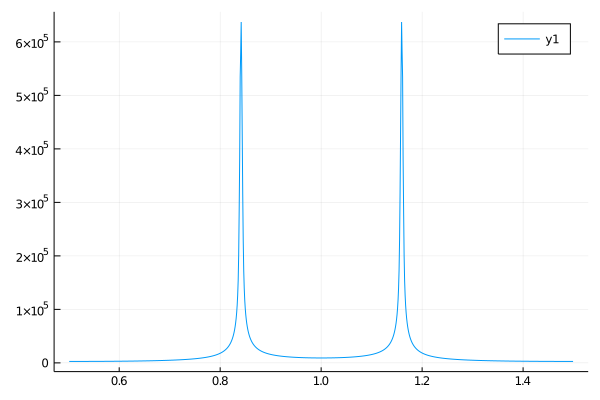

In [41]:
using FFTW
using Distributions

x = collect(LinRange(0, 1000, 1000))
ν0 = 1
ω = rand(Normal(ν0, 0.01), 10000)
y = sin.(x)
for i = 1:length(ω)
    y += sin.(ω[i].*x) # .+ rand(Normal(0, 5), length(x))
end


L = length(y)
xL = 1
xR = length(x)
window = x[xR] - x[xL] # total amount of time encompassed by signal

 # window time array and time step, starting at zero
t = collect(LinRange(0, window, size(y[xL:xR], 1)))
dt = t[2]-t[1]

# the truncated signal
y_trunc = y[xL:xR]

# figure out the "frequency axis" after the fft
fs = 1/dt
n = length(y_trunc)
f = (((0:n-1) .+ 1/2)/n .- 1/2)*fs;

y_fft = fftshift(fft(y_trunc))
p1 = plot(f.+ν0, broadcast(abs, y_fft))

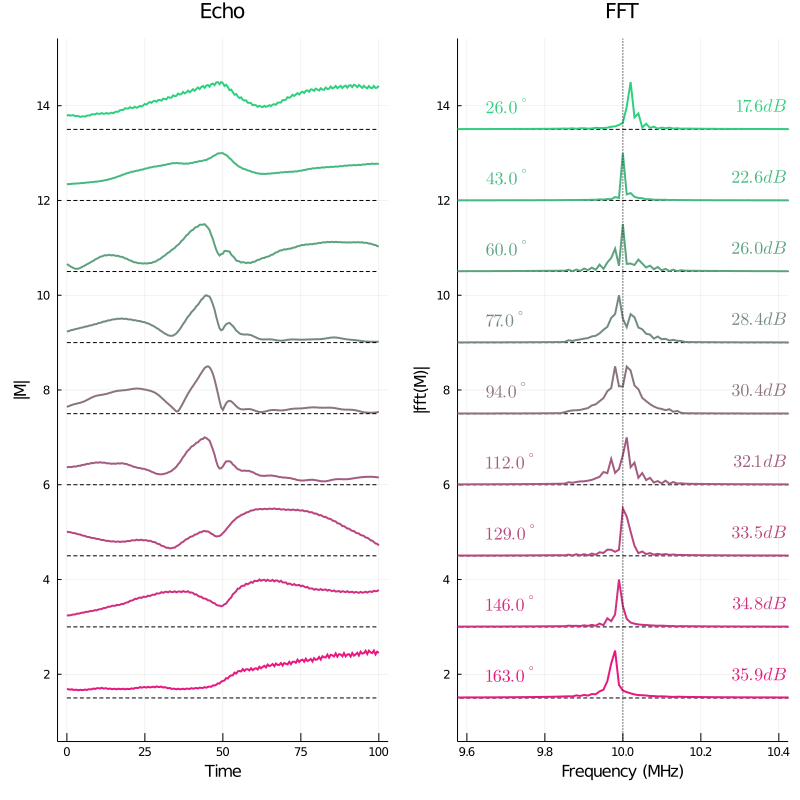

In [123]:
using FFTW
using LaTeXStrings

@load "α_vs_f_phase_01_M_list.jld2" M_list
S1 = M_list
@load "α_vs_f_phase_03_M_list.jld2" M_list
S2 = M_list

S3 = S1 .+ S2
M_list = S3;

idx = 7

M_list = M_list[idx,:]
f = LinRange(0.1, 2, 11)

#tar_alph = 5;
#println(α[tar_alph])
plt1 = plot()
plt2 = plot()
ν0 = params["ν0"]

n_keep = 1;
dt_start = 300;
dt_end = 300;


# loop over the pulse strengths
for f0 = 2:length(f)-1
    
    # load in the M data
    M0 = convert(Array{Complex{Float64}},M_list[f0])
    nt = size(M0, 1);
    xL = nt/5

    # select a truncated window to FFT
    M0_trunc = M0[convert(Int64,round(2*nt/3 - xL)):convert(Int64,round(2*nt/3 + xL))]
    t_max = n_keep*100; # 200 micro seconds
    t = LinRange(0, t_max, size(M0_trunc, 1));
    dt = t[2]-t[1];

    # figure out the "frequency axis" after the FFT
    Fs = 1/dt; 
    N = length(M0_trunc)
    freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;

    # labeling
    ang_here = (f[f0]*90);
    P0 = f[1]*0.5;
    pulse_str = 10*log(f[f0]/P0)
    db_str = latexstring(string(round(pulse_str,digits=1))*" dB")
    ang_str = latexstring(round(ang_here),"^\\circ");
    color_here = RGB(f0/length(f),1-f0/length(f),0.5)
    
    # plot the time-domian results
    M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
    M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
    plot!(plt1,t, M0_trunc_abs .+ 1.5*(length(f)-f0),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    plot!(plt1,t, 0*M0_trunc_abs .+ 1.5*(length(f)-f0),color=RGB(0,0,0),linestyle=:dash,label="")
    
    # FFT!
    M0_fft = fftshift(fft(M0_trunc))

    M0_fft = M0_fft/maximum(broadcast(abs,M0_fft)) # normalize
    plot!(plt2,freq_ax .+ ν0, 0*broadcast(abs,M0_fft) .+ 1.5*(length(f)-f0),color=RGB(0,0,0),linestyle=:dash,label="")
    plot!(plt2,freq_ax .+ ν0,broadcast(abs,M0_fft) .+ 1.5*(length(f)-f0),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

    annotate!(plt2,10.42,0.5+1.5*(length(f)-f0),text(db_str,color_here, :right,12))
    annotate!(plt2,9.65,0.5+1.5*(length(f)-f0),text(ang_str,color_here, :left,12))

end

plot!(plt2,ν0 .+ [0,0],[0, 1.5*(length(f)+1)],color=RGB(0,0,0),label="",linestyle=:dot)

xlabel!(plt1,"Time")
ylabel!(plt1,"|M|")
xlabel!(plt2,"Frequency (MHz)")
ylabel!(plt2,"|fft(M)|")

plot!(plt1,ylim=[1,15])
plot!(plt2,ylim=[1,15])

title!(plt1,"Echo")
title!(plt2,"FFT")

pt = plot(plt1, plt2, size = (800,800))
display(pt)

# α = collect(LinRange(0.05,0.2,9))
# pushfirst!(α, 0)
# display(α[idx])
savefig("α_0p2.png")

In [114]:
α = round.(collect(LinRange(0.1, 0.2, 6)), digits = 2)
pushfirst!(α, 0)

display(α)

7-element Array{Float64,1}:
 0.0
 0.1
 0.12
 0.14
 0.16
 0.18
 0.2